# Start modelling beta as a powerlaw instead of uniform (this saves the divergence in the 0x2 term provided the power is <-2)

In [1]:
%load_ext autoreload
# to make modification in .py file type %autoreload

In [2]:
%load_ext line_profiler
#for finding out how long code takes to run

In [119]:
#trying to consolidate the work so far into a cohesive document and notation. Pushing definitions into 
#separate .py file

#------packages-------------------
%pylab inline
import time
import healpy as hp
import foreground_functions as ff
import scipy.special as sp #for the zeta function sp.zeta() in the 0x2 term


#-------BB parameters (to start)--------
A_BB = 1.7e3
alpha_BB = -3.0
beta_BB = -3.2
beta_sigma = 1.5e-6

A_beta = 1e-6
gamma_BB = -2.5 #needs to be less than -2 for the 0x2 term to converge
nu0 = 2.3e9

#-------map paramters--------------------
nside = 128
Lmax = 384
ell_sum_384 = 384
ell_sum_800 = 800
ells = np.arange(0,Lmax)
extended_ells = np.arange(1,ell_sum_800+1)

#define list of frequencies going from 10 to 300 GHz, sampling 20 points
freqs = np.linspace(30,300,4)*1.e9

#---realisations
N=10

Populating the interactive namespace from numpy and matplotlib


In [120]:
%autoreload

In [121]:
#an example of how to get diagnostics on functions
#%lprun -f ff.generate_map_full ff.generate_map_full(384, A_BB, alpha_BB, beta_sigma, freqs, nu0)

# We want to now use a beta as a power law kind of thing, rather than uniform C_ells from the beta map

In [122]:
bcls, check_bcls, beta_map = ff.map_power_beta(gamma=gamma_BB)

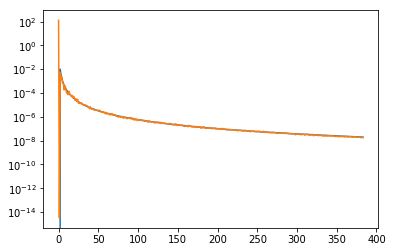

In [123]:
semilogy(ells, bcls)
semilogy(ells, check_bcls);

# Test that each function works in turn

In [124]:
#powerlaw without division by 0 error
power = ff.powerlaw(ells, alpha_BB)

In [125]:
#SED related stuff
synch_test_0 = ff.normed_synch(freqs[0], beta_BB)
synch_test_1 = ff.scale_synch(freqs, beta_BB)
synch_test_2 = ff.scale_synch(freqs, beta_map)

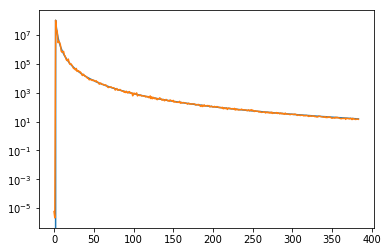

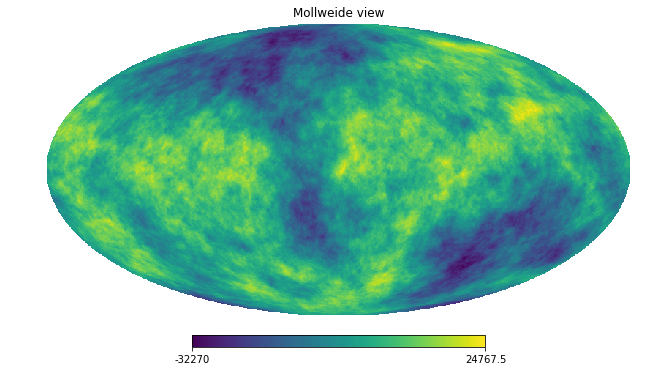

In [126]:
pcls, check_pcls, amp_map = ff.map_amp()

semilogy(ells, pcls)
semilogy(ells, check_pcls)
hp.mollview(amp_map)

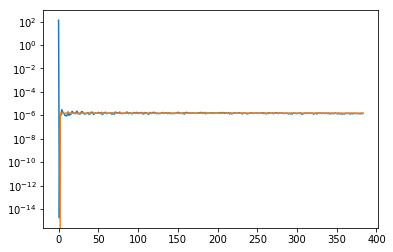

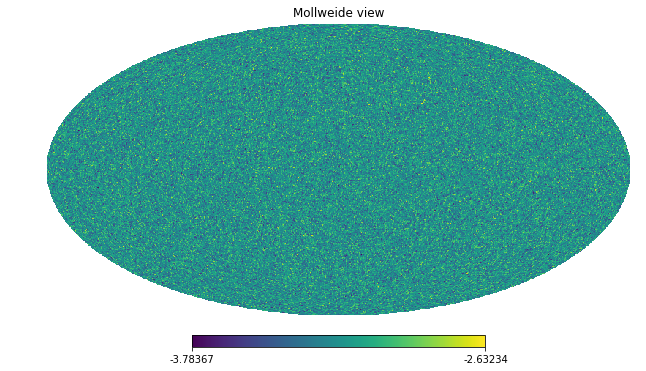

In [127]:
bcls_1, check_bcls_1, beta_map_1 = ff.map_beta()

semilogy(ells, check_bcls_1)
semilogy(ells, bcls_1)
hp.mollview(beta_map_1)

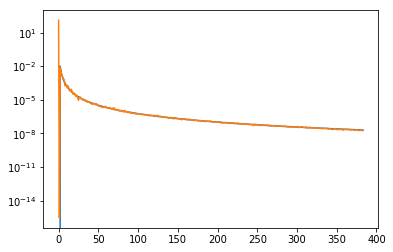

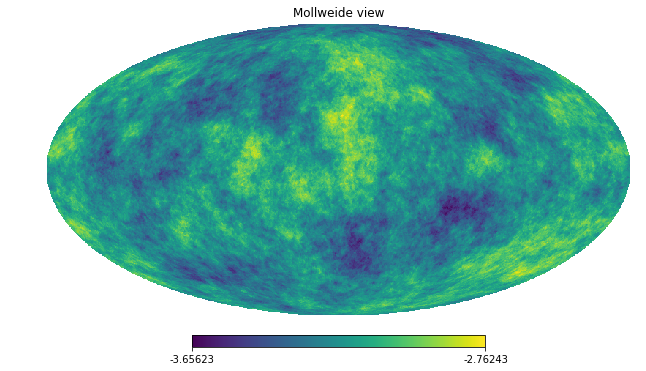

In [128]:
bcls_2, check_bcls_2, beta_map_2 = ff.map_power_beta()

semilogy(ells, bcls_2)
semilogy(ells, check_bcls_2)
hp.mollview(beta_map_2)

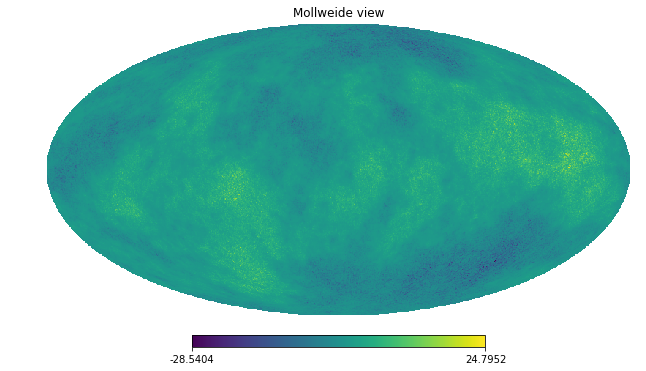

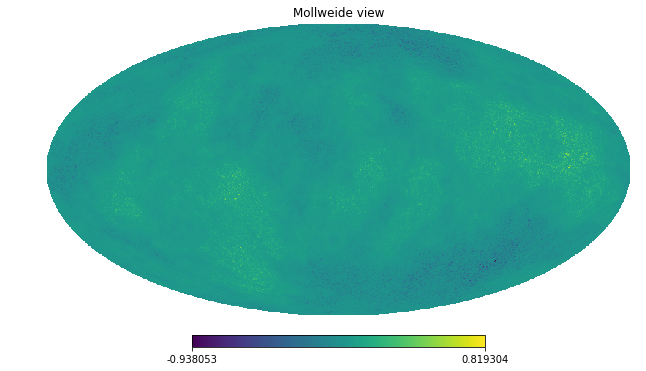

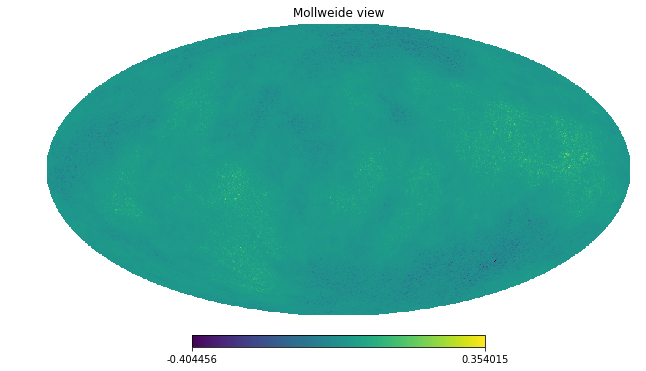

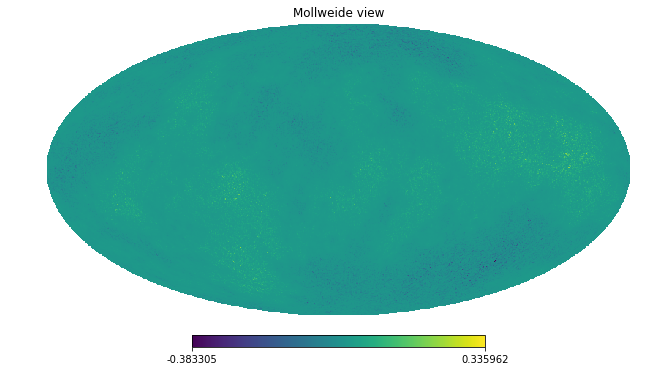

In [129]:
#these have constant beta power spectra/white noise
newmaps_1 = ff.map_full_white(freqs)
for i in range(len(freqs)):
    hp.mollview(newmaps_1[i])

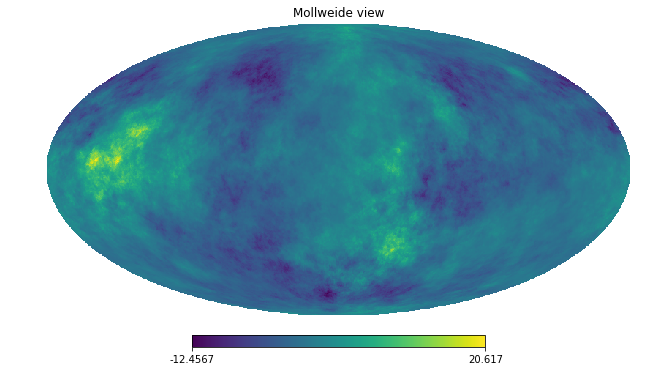

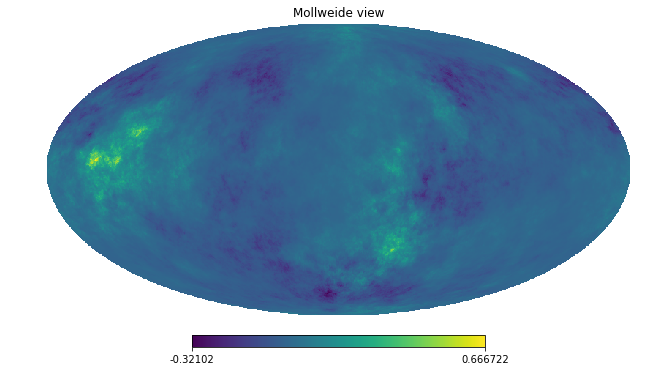

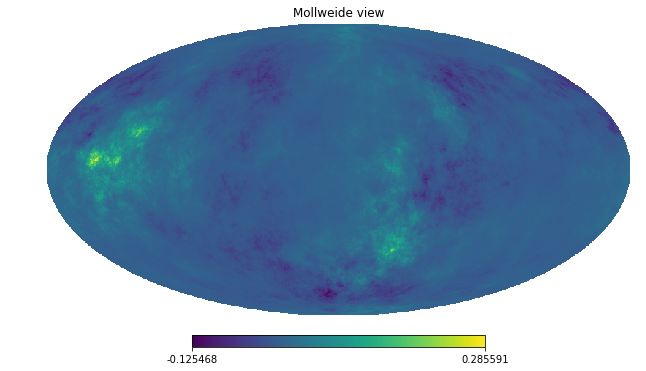

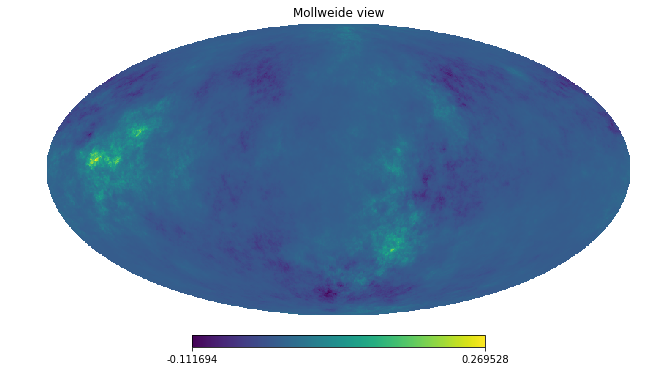

In [130]:
#these should generate full maps at with power law beta
newmaps_2 = ff.map_full_power(freqs)
for i in range(len(freqs)):
    hp.mollview(newmaps_2[i])

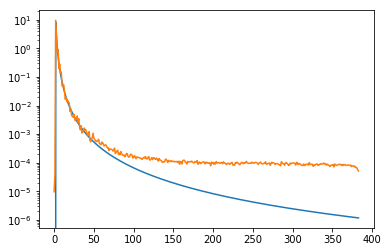

In [131]:
#0x0 moment function works
moment0x0 = ff.auto0x0(freqs)
semilogy(ells, moment0x0[0])
semilogy(ells, hp.anafast(newmaps_1[0]));

In [132]:
%autoreload

In [133]:
#1x1 moment function works
amp_cls = A_BB * ff.powerlaw(ells, alpha_BB)
beta_cls = bcls_2

moment1x1 = ff.auto1x1(freqs, amp_cls, beta_cls)

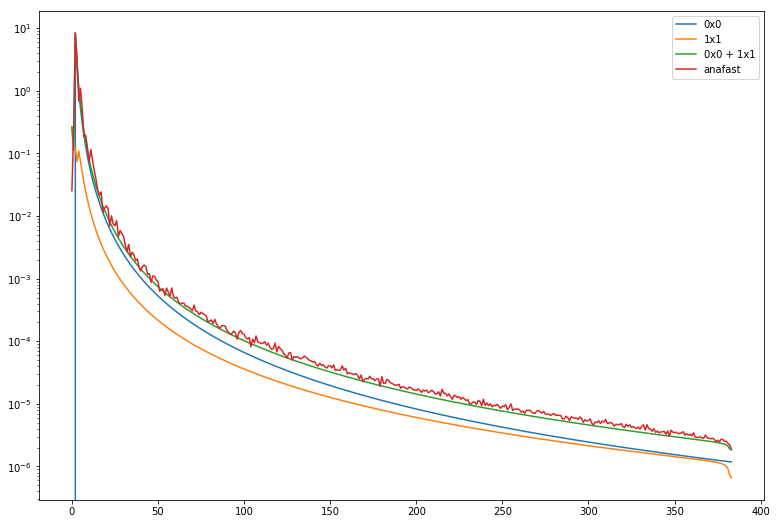

In [134]:
figure(figsize=(13,9))
semilogy(ells, moment0x0[0], label='0x0')
semilogy(ells, moment1x1[0], label='1x1')
semilogy(ells, moment0x0[0]+moment1x1[0], label='0x0 + 1x1')
semilogy(ells, hp.anafast(newmaps_2[0]), label='anafast')
legend();

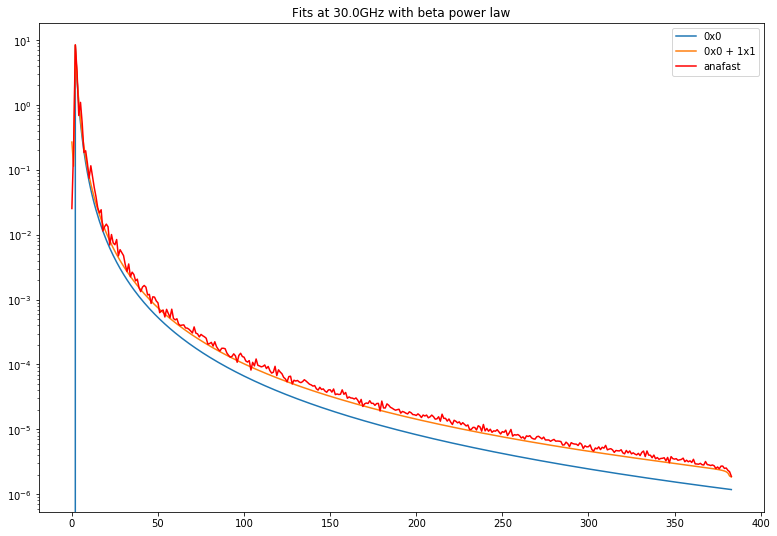

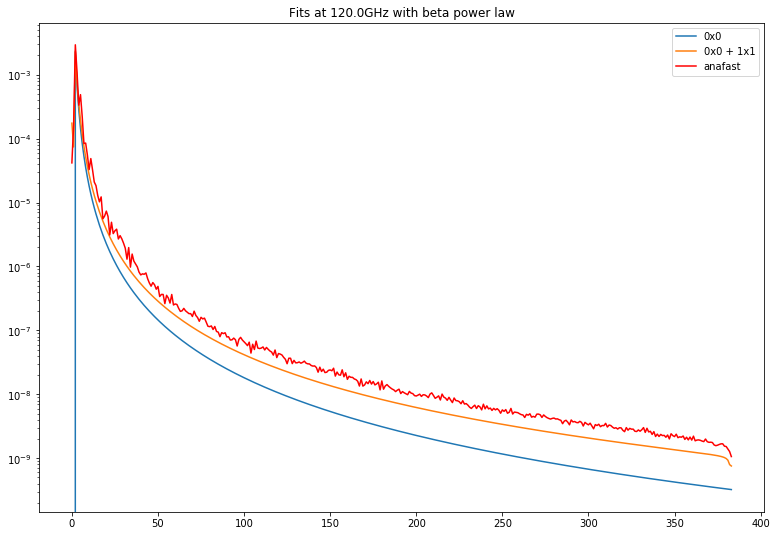

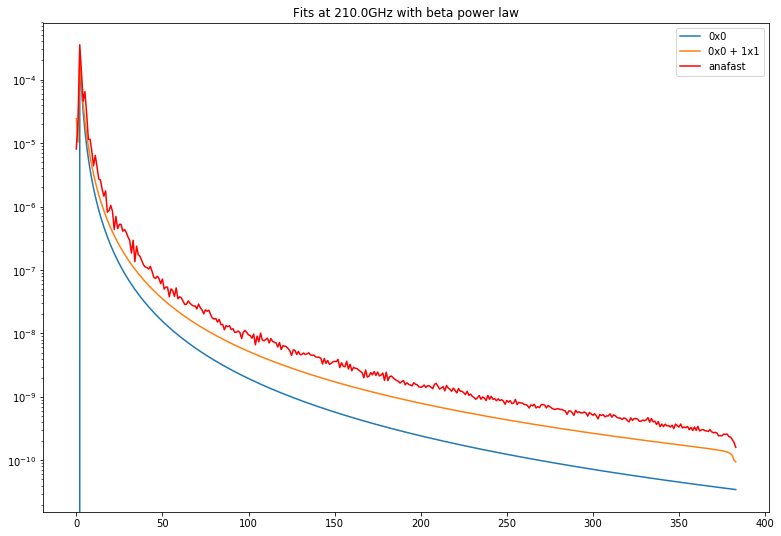

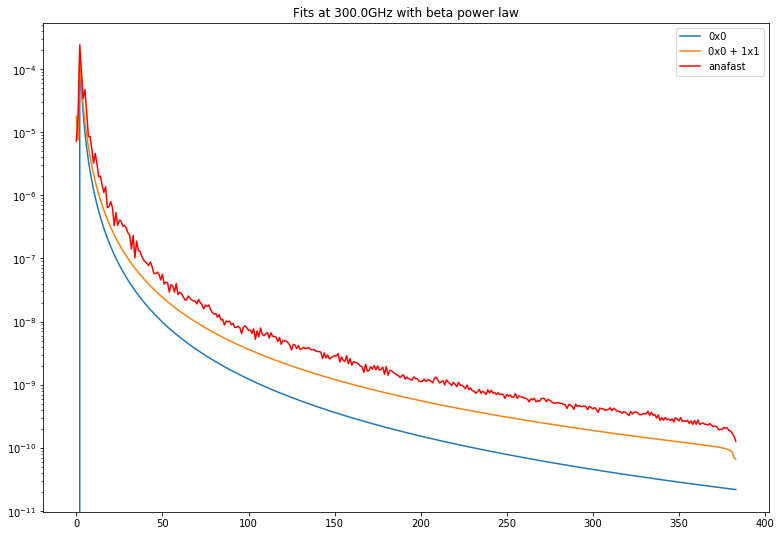

In [135]:
for i in range(len(freqs)):
    figure(figsize=(13,9))
    semilogy(ells, moment0x0[i], label='0x0')
#     semilogy(ells, moment1x1[i], label='1x1')
    semilogy(ells, moment0x0[i]+moment1x1[i], label='0x0 + 1x1')
    semilogy(ells, hp.anafast(newmaps_2[i]), 'r', label='anafast')
    title('Fits at ' + str(np.round(freqs[i]*1e-9)) + 'GHz with beta power law')
    legend();

# Code up the 0x2 moment

In [136]:
#write a function to perform the 0x2 sum
def mom0x2_sum(ell_max, bcls):
    sum = 0
    for ell1 in range(int(ell_max)):
        sum += (2*ell1 + 1)/(4*pi) * bcls[ell1]
    return sum

diff is 0.0003553385713579542
time taken is 0.5625309944152832


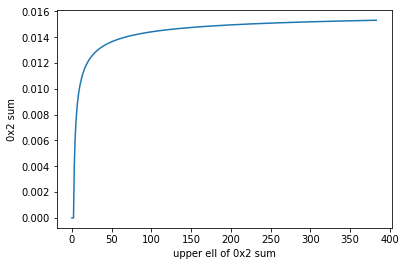

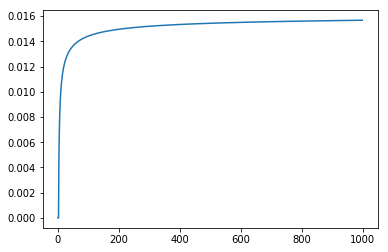

In [137]:
start=time.time()
BIG=int(1e3)
bcls_long, check_bcls_long, beta_map_long = ff.map_power_beta(ell_max=BIG, gamma=gamma_BB)

figure()
y = []
for i in range(0,384):
    y_i = mom0x2_sum(i, beta_cls)
    y.append(y_i)

x = range(0,384)
plot(x, y)
xlabel('upper ell of 0x2 sum')
ylabel('0x2 sum')

x1 = range(0,BIG)
figure()
z = []
for i in range(0,BIG):
    z_i = mom0x2_sum(i,bcls_long)
    z.append(z_i)
    
plot(x1,z)

print('diff is ' +str(z[-1]-y[-1]))

print('time taken is ' + str(time.time()-start))


In [138]:
#can estimate the upper bound on this sum by the integral from 2 to inf
#(can ignore the integral before 2 as the beta_cls are 0 there)
def mom0x2_bound(gamma):
    a = -3*gamma-4
    b = 4*pi*(80**gamma) * (gamma**2 + 3 * gamma + 2)
    return a/b

bound = mom0x2_bound(gamma_BB)
print(bound)

21257.974630059685


In [139]:
#check prefactors and things
def mom0x2_limit(gamma):
    a = 2 * sp.zeta(-gamma-1) + sp.zeta(-gamma)-3
    b = 4*pi*(80**gamma) 
    return A_beta * a/b

In [140]:
lim = mom0x2_limit(gamma_BB)
print(lim)
#wolfram gives 0.0162452 for the default vaules of the parameters I'm using

0.016245213420880318


In [141]:
sed_scaling = ff.scale_synch(freqs, beta_BB, nu0=nu0)
moment0x2 = np.zeros((len(freqs),len(ells)))
sum0x2 = mom0x2_limit(gamma_BB)
print(sum0x2)
for i in range(len(moment0x2[:,0])):
        moment0x2[i] =  np.log(freqs[i]/nu0)**2 * sed_scaling[i]**2 * amp_cls * sum0x2

0.016245213420880318


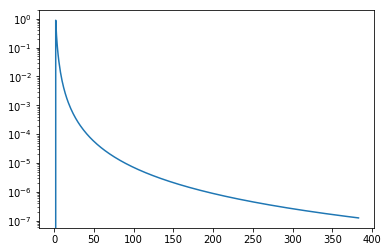

In [142]:
semilogy(ells, moment0x2[0])

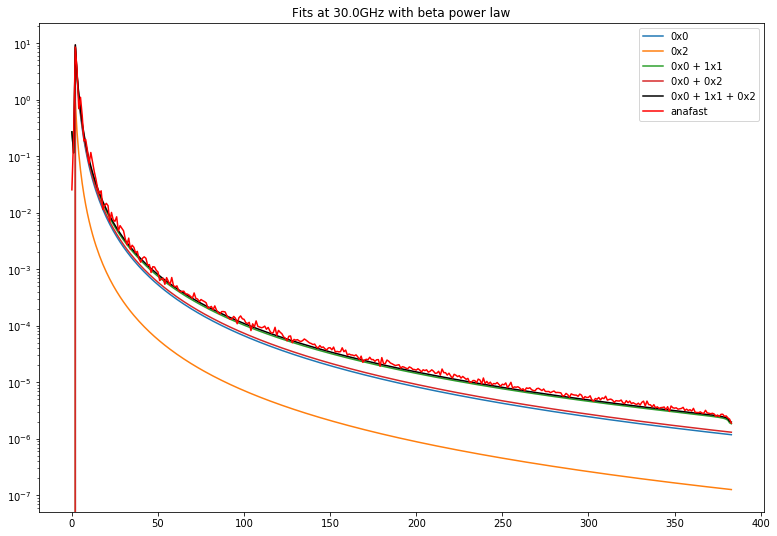

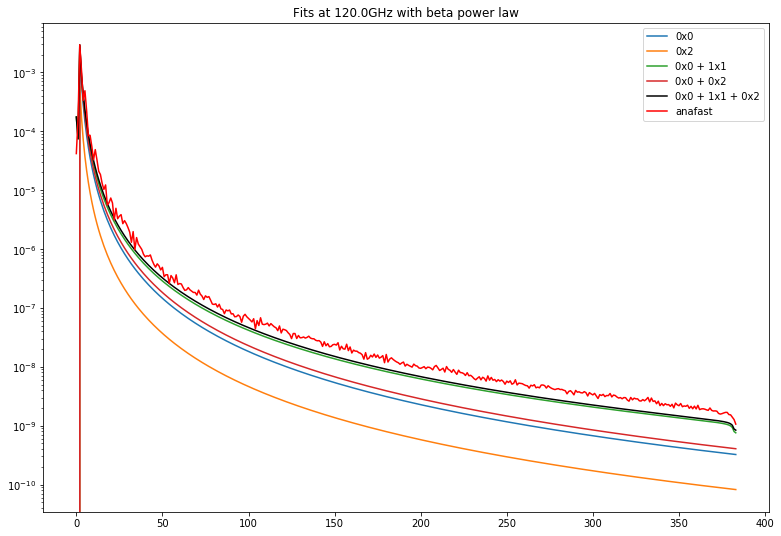

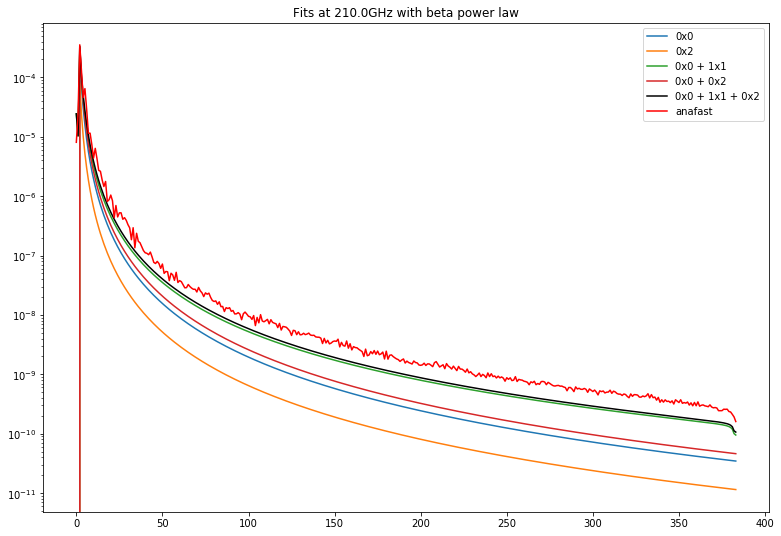

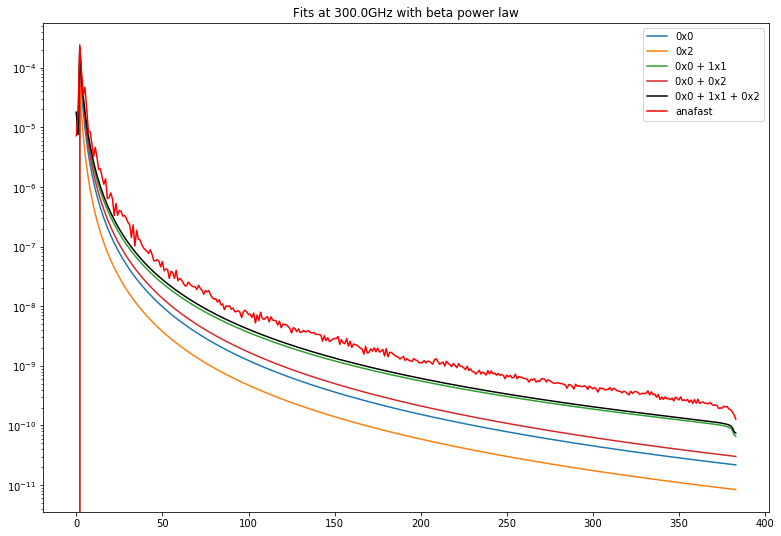

In [143]:
for i in range(len(freqs)):
    figure(figsize=(13,9))
    semilogy(ells, moment0x0[i], label='0x0')
#     semilogy(ells, moment1x1[i], label='1x1')
    semilogy(ells, moment0x2[i], label='0x2')
    semilogy(ells, moment0x0[i]+moment1x1[i], label='0x0 + 1x1')
    semilogy(ells, moment0x0[i]+moment0x2[i], label='0x0 + 0x2')
    semilogy(ells, moment0x0[i]+moment1x1[i]+moment0x2[i], 'k', label='0x0 + 1x1 + 0x2')
    semilogy(ells, hp.anafast(newmaps_2[i]), 'r', label='anafast')
    title('Fits at ' + str(np.round(freqs[i]*1e-9)) + 'GHz with beta power law')
    legend();